# Parameter ID Part 2:

Code Written by Nathan Mayer

Code Adapted from the Triple Pendulum Example, Solving Nonlinear Four-Bar Constraints, and Falling Rod Example Code Written by Professor Daniel Aukes

Triple Pendulum Example Code: https://foldable-robotics.github.io/modules/dynamics/generated/08-triple-pendulum-example/

The purpose of this script was to take the equations developed for the position of the end effector through the biological system tracking and run a simulation of the end effector mapped to this point. Therefore, over time, the system would trace the position of the end effector to this desired position by adjusting the joint angles within the five bar mechanism. After the simulation was run, data regarding the two servo-actuated angles, Angle qA2 and Angle qB1, could be retrieved, plotted, and then fit as a basic sinesoidal function that could be used as control algorithms to drive the motors in the physical experimentation.

##Pynamics Script:

In [1]:
use_constraints = True

In [2]:
# Import all necessary packages:

!pip install pynamics
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint,KinematicConstraint
import pynamics.integration
import numpy
import sympy
import scipy.optimize
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [3]:
# Define Initial System:

system = System()
pynamics.set_system(__name__,system)

### Parametrization:

Link lengths were based off of dimensionless values used to create the initial Solidworks sketch, and then scaled by 1/20 to get the model to the appropriate size. Currently, the fixed horizontal link at the top of the model (link A1) is 5cm long.

Masses of the individual links and the body of the robot (not represented in simulation but referenced with respect to the ground contact forces) are somewhat arbitrary at this point but are roughly in-line with a small dog, which the system is mimicking. These values can easily be adjusted based on the material selections and electronic component choices at a later date.

In [4]:
# Create constant values for length, mass, springs, inertia, etc.

lA1 = Constant(0.05,'lA1',system)
lB1 = Constant(0.05,'lB1',system)
lC1 = Constant(0.05,'lC1',system)
lA2 = Constant(0.05,'lA2',system)
lB2 = Constant(0.05,'lB2',system)
lA3 = Constant(0.085+0.05,'lA3',system)

mA1 = Constant(0.006,'mA1',system)
mB1 = Constant(0.006,'mB1',system)
mC1 = Constant(0.006,'mC1',system)
mA2 = Constant(0.006,'mA2',system)
mB2 = Constant(0.006,'mB2',system)
mA3 = Constant(0.009,'mA3',system)
m_end = Constant(0,'m_end',system)

m_Rig = Constant(0.2,'m_body',system)

g = Constant(9.81,'g',system) # acceleration due to gravity
b = Constant(1e-4,'b',system) # damping constant
k = Constant(1e-7,'k',system) # spring constant
k_ground = Constant(2e4,'k_ground',system) # ground spring constant
b_ground = Constant(8e5,'b_ground',system) # ground damping constant

# spring preloads
preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preload4 = Constant(0*pi/180,'preload4',system)
preload5 = Constant(0*pi/180,'preload5',system)
preload6 = Constant(0*pi/180,'preload6',system)

# link principal moments of inertia
Ixx_A1 = Constant(4.167*10**-9,'Ixx_A1',system)
Iyy_A1 = Constant(1,'Iyy_A1',system)
Izz_A1 = Constant(1.042*10**-7,'Izz_A1',system)
Ixx_B1 = Constant(4.167*10**-9,'Ixx_B1',system)
Iyy_B1 = Constant(1,'Iyy_B1',system)
Izz_B1 = Constant(1.042*10**-7,'Izz_B1',system)
Ixx_C1 = Constant(4.167*10**-9,'Ixx_C1',system)
Iyy_C1 = Constant(1,'Iyy_C1',system)
Izz_C1 = Constant(1.042*10**-7,'Izz_C1',system)
Ixx_A2 = Constant(4.167*10**-9,'Ixx_A2',system)
Iyy_A2 = Constant(1,'Iyy_A2',system)
Izz_A2 = Constant(1.042*10**-7,'Izz_A2',system)
Ixx_B2 = Constant(4.167*10**-9,'Ixx_B2',system)
Iyy_B2 = Constant(1,'Iyy_B2',system)
Izz_B2 = Constant(1.042*10**-7,'Izz_B2',system)
Ixx_A3 = Constant(6.666*10**-9,'Ixx_A3',system)
Iyy_A3 = Constant(1,'Iyy_A3',system)
Izz_A3 = Constant(3.7*10**-7,'Izz_A3',system)

qA3 = Constant(0,'qA3',system)

In [5]:
# Differentiable State Variables:

qA1,qA1_d,qA1_dd = Differentiable('qA1',system)
qB1,qB1_d,qB1_dd = Differentiable('qB1',system)
qC1,qC1_d,qC1_dd = Differentiable('qC1',system)
qA2,qA2_d,qA2_dd = Differentiable('qA2',system)
qB2,qB2_d,qB2_dd = Differentiable('qB2',system)

In [6]:
# Initial Values:

initialvalues = {}
initialvalues[qA1]=(0)*pi/180
initialvalues[qA1_d]=0*pi/180
initialvalues[qB1]=(-110)*pi/180
initialvalues[qB1_d]=0*pi/180
initialvalues[qC1]=(-40)*pi/180
initialvalues[qC1_d]=0*pi/180
initialvalues[qA2]=(-130)*pi/180
initialvalues[qA2_d]=0*pi/180
initialvalues[qB2]=(70)*pi/180
initialvalues[qB2_d]=0*pi/180


In [7]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

### Kinematics:

In [8]:
# Define All Frames:

N = Frame('N',system)
A1 = Frame('A1',system)
B1 = Frame('B1',system)
C1 = Frame('C1',system)
A2 = Frame('A2',system)
B2 = Frame('B2',system)
A3 = Frame('A3',system)

In [9]:
# Define Newtonian Frame:

system.set_newtonian(N)

In [10]:
# Define Frame Rotations:

A1.rotate_fixed_axis(N,[0,0,1],qA1,system)
B1.rotate_fixed_axis(A1,[0,0,1],qB1,system)
C1.rotate_fixed_axis(B1,[0,0,1],qC1,system)
A2.rotate_fixed_axis(N,[0,0,1],qA2,system)
B2.rotate_fixed_axis(A2,[0,0,1],qB2,system)
A3.rotate_fixed_axis(B2,[0,0,1],qA3,system)

In [11]:
# Create Point Vectors based on Frame Rotations:

pNA1 = 0*N.x
pA1B1 = pNA1 + lA1*A1.x
pB1C1 = pA1B1 + lB1*B1.x
pC1B2 = pB1C1 + lC1*C1.x

pNA2 = 0*N.x
pA2B2 = pNA2 + lA2*A2.x
pB2C1 = pA2B2 + lB2*B2.x

pB2A3 = pA2B2 + lA3*B2.x

# Define Conditions of the End Effector Ellipse Path and Define the Initial Starting Point
x_start = Constant(0.09,'x_start',system)
y_start = Constant(-0.115,'y_start',system)
sz = Constant(1/2,'sz',system)
freq = Constant(1.5,'freq',system)
y_adjust = Constant(-0.003,'y_adjust',system)
pEnd = ((-0.0749732645592911*sympy.sin(0)*sz+x_start))*N.x + ((-0.0217365930025405+y_adjust)*sympy.sin(1.57)+y_start)*N.y

In [12]:
# Create Particle Entity to be Used in Ground Contact Force

Particle1 = Particle(pA1B1,m_end,'Particle1',system)

In [13]:
# Create an array of points:

points = [pC1B2,pB1C1,pA1B1,pNA1,pNA2,pA2B2,pB2C1,pB2A3]

p = numpy.array(points)

In [14]:
# Plot Estimated System Position:

l = len(p)

state1 = initialvalues


px = []
for i in range(0,l):
    q = p[i]
    x = q.dot(N.x)
    px.append(x)

px1 = [item.subs(state1) for item in px]
px1 = [item.subs(system.constant_values) for item in px1]
print('px1: ')
print(px1)

py = []
for i in range(0,l):
    q = p[i]
    y = q.dot(N.y)
    py.append(y)

py1 = [item.subs(state1) for item in py]
py1 = [item.subs(system.constant_values) for item in py1]
print('py1: ')
print(py1)

pz = []
for i in range(0,l):
    q = p[i]
    z = q.dot(N.z)
    pz.append(z)

pz1 = [item.subs(state1) for item in pz]
pz1 = [item.subs(system.constant_values) for item in pz1]
print('pz1: ')
print(pz1)

px1: 
[-0.0104022773555054, 0.0328989928337166, 0.0500000000000000, 0, 0, -0.0321393804843270, -0.00713938048432698, 0.0353606195156730]
py1: 
[-0.0719846310392954, -0.0469846310392954, 0, 0, 0, -0.0383022221559489, -0.0816034923451708, -0.155215651666848]
pz1: 
[0, 0, 0, 0, 0, 0, 0, 0]


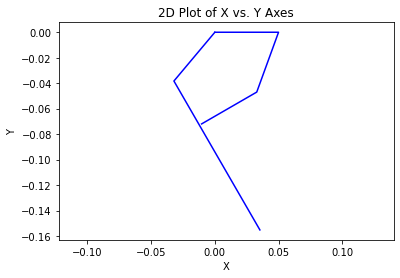

In [15]:
# 2D Plot (X vs. Y Axes)

plt.plot(px1[0:4],py1[0:4],'b')
plt.plot(px1[4:l],py1[4:l],'b')
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot of X vs. Y Axes');

### Solve for valid initial condition determined by independent variable:
## Part 1: Set End Effector to Starting Position

In [16]:
# Setup Optimization Equations:

ini0 = [initialvalues[item] for item in statevariables]

eq_vector = [pB2A3-pEnd]
eq_scalar = []
eq_scalar.append((eq_vector[0]).dot(N.x))
eq_scalar.append((eq_vector[0]).dot(N.y))

eq_scalar

[lA2*cos(qA2) - lA3*sin(qA2)*sin(qB2) + lA3*cos(qA2)*cos(qB2) - x_start, lA2*sin(qA2) + lA3*sin(qA2)*cos(qB2) + lA3*sin(qB2)*cos(qA2) - 0.999999682931835*y_adjust - y_start + 0.0217365861105588]

In [17]:
# Define Independent and Dependent Variables

qi = [qA1,qB1,qC1]
qd = [qA2,qB2]

eq_scalar_c = [item.subs(system.constant_values) for item in eq_scalar]

defined = dict([(item,initialvalues[item]) for item in qi])
eq_scalar_c = [item.subs(defined) for item in eq_scalar_c]
eq_scalar_c

error = (numpy.array(eq_scalar_c)**2).sum()


In [18]:
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [19]:
# Define Initial Guess and Use Optimize Equation to Find Actual Angles:

guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-7:
    raise(Exception("out of tolerance"))

In [20]:
# Save New Points to Plot the Actual System Results:

ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

In [21]:
# Display Error from Optimization Equation:
result.fun

6.110779096731207e-09

In [22]:
# Plot Calculated System (Orange) vs. Initial Guess (Blue)

#points = PointsOutput(points, constant_values=system.constant_values)
#points.calc(numpy.array([ini0,ini]),numpy.array([0,1]))
#points.plot_time()

In [23]:
# Define a new State for Joint Angles based on Optimization Equation:

state2 = {}
state2[qA1] = initialvalues[qA1]
state2[qA1_d]= 0*pi/180
state2[qB1]= initialvalues[qB1]
state2[qB1_d] = 0*pi/180
state2[qC1] = initialvalues[qC1]
state2[qC1_d] = 0*pi/180
state2[qA2] = result.x[0]
state2[qA2_d] = 0*pi/180
state2[qB2] = result.x[1]
state2[qB2_d] = 0*pi/180

## Part 2: Solve Five Bar Kinematic Constraint

In [24]:
# Setup Optimization Equations:

eq_vector = [pB2C1-pC1B2] # Output Should be Zero when End Points from Each Segment are Subtracted

eq_scalar = []
eq_scalar.append((eq_vector[0]).dot(N.x))
eq_scalar.append((eq_vector[0]).dot(N.y))

eq_scalar

[-lA1*cos(qA1) + lA2*cos(qA2) + lB1*sin(qA1)*sin(qB1) - lB1*cos(qA1)*cos(qB1) - lB2*sin(qA2)*sin(qB2) + lB2*cos(qA2)*cos(qB2) - lC1*(-sin(qA1)*sin(qB1) + cos(qA1)*cos(qB1))*cos(qC1) - lC1*(-sin(qA1)*cos(qB1) - sin(qB1)*cos(qA1))*sin(qC1), -lA1*sin(qA1) + lA2*sin(qA2) - lB1*sin(qA1)*cos(qB1) - lB1*sin(qB1)*cos(qA1) + lB2*sin(qA2)*cos(qB2) + lB2*sin(qB2)*cos(qA2) - lC1*(-sin(qA1)*sin(qB1) + cos(qA1)*cos(qB1))*sin(qC1) - lC1*(sin(qA1)*cos(qB1) + sin(qB1)*cos(qA1))*cos(qC1)]

In [25]:
# Define Independent and Dependent Variables

qi = []
qd = []
qi = [qA1,qA2,qB2]
qd = [qB1,qC1]

eq_scalar_c = [item.subs(system.constant_values) for item in eq_scalar]

defined = dict([(item,state2[item]) for item in qi])
eq_scalar_c = [item.subs(defined) for item in eq_scalar_c]
eq_scalar_c

error = (numpy.array(eq_scalar_c)**2).sum()


In [26]:
qd

[qB1, qC1]

In [27]:
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [28]:
result.fun

6.110779096731207e-09

In [29]:
# Define Initial Guess and Use Optimize Equation to Find Actual Angles:

guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-7:
    raise(Exception("out of tolerance"))

In [30]:
# Save New Points to Plot the Actual System Results:

ini_c = []
for item in system.get_state_variables():
    if item in qd:
        ini_c.append(result.x[qd.index(item)])
    else:
        ini_c.append(state2[item])

In [31]:
# Display Error from Optimization Equation:
result.fun

5.466114219737483e-08

2022-04-27 20:26:20,199 - pynamics.output - INFO - calculating outputs
2022-04-27 20:26:20,201 - pynamics.output - INFO - done calculating outputs


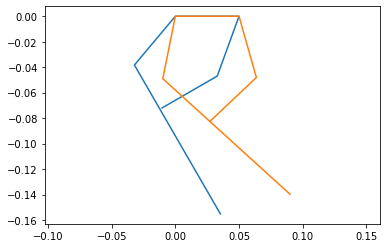

In [32]:
# Plot Calculated System (Orange) vs. Initial Guess (Blue)

points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini_c]),numpy.array([0,1]))
points.plot_time()

In [33]:
state2[qB1]= result.x[0]
state2[qB1_d] = 0*pi/180
state2[qC1] = result.x[1]
state2[qC1_d] = 0*pi/180

# Dynamics Simulation:

## Centers of Mass:

The centers of mass of each link are taken at the centers of their respective linear segments.

In [34]:
pA1cm=pNA1+lA1/2*A1.x
pB1cm=pA1B1+lB1/2*B1.x
pC1cm=pB1C1+lC1/2*C1.x
pA2cm=pNA2+lA2/2*A2.x
pB2cm=pA2B2+lB2/2*B2.x
pA3cm=pB2A3+lA3/2*A3.x

## Angular Velocity:

In [35]:
wNA1 = N.get_w_to(A1)
wA1B1 = A1.get_w_to(B1)
wB1C1 = B1.get_w_to(C1)
wNA2 = N.get_w_to(A2)
wA2B2 = A2.get_w_to(B2)
wB2A3 = B2.get_w_to(A3)

## Vector Derivatives:

In [36]:
vA3Tip = pB2A3.time_derivative(N,system)
vEnd = pEnd.time_derivative(N,system)
vA1B1 = pA1B1.time_derivative(N,system)

## Define Inertias and Bodies:

Inertias and bodies are constructed from previosly defined masses, centers of mass, and moments of intertia.

In [37]:
IA1 = Dyadic.build(A1,Ixx_A1,Iyy_A1,Izz_A1)
IB1 = Dyadic.build(B1,Ixx_B1,Iyy_B1,Izz_B1)
IC1 = Dyadic.build(C1,Ixx_C1,Iyy_C1,Izz_C1)
IA2 = Dyadic.build(A2,Ixx_A2,Iyy_A2,Izz_A2)
IB2 = Dyadic.build(B2,Ixx_B2,Iyy_B2,Izz_B2)
IA3 = Dyadic.build(A3,Ixx_A3,Iyy_A3,Izz_A3)

BodyA1 = Body('BodyA1',A1,pA1cm,mA1,IA1,system)
BodyB1 = Body('BodyB1',B1,pB1cm,mB1,IB1,system)
BodyC1 = Body('BodyC1',C1,pC1cm,mC1,IC1,system)
BodyA2 = Body('BodyA2',A2,pA2cm,mA2,IA2,system)
BodyB2 = Body('BodyB2',B2,pB2cm,mB2,IB2,system)
BodyA3 = Body('BodyA3',A3,pA3cm,mA3,IA3,system)

## Forces and Torques: (Using Pynamics Simulation)

Two sinusoidal input torques are considered acting at joints $p(NA_1)$ and $p(A_1A_2)$. These torques currently have an amplitude of 1 N*m but can be adjusted later.

Dampers and spring forces are added to each of the joints so that their values can be studied and different combinations can be tested in the future. Gravity and ground contact forces are included as well.

In [38]:
# Damper:

system.addforce(-b*wNA1,wNA1)
system.addforce(-b*wA1B1,wA1B1)
system.addforce(-b*wB1C1,wB1C1)
system.addforce(-b*wNA2,wNA2)
system.addforce(-b*wA2B2,wA2B2)
system.addforce(-b*wB2A3,wB2A3)

In [39]:
# Spring Forces:

system.add_spring_force1(k,(qA1-preload1)*N.z,wNA1) 
system.add_spring_force1(k,(qB1-preload2)*A1.z,wA1B1)
system.add_spring_force1(k,(qC1-preload3)*B1.z,wB1C1)
system.add_spring_force1(k,(qA2-preload4)*N.z,wNA2) 
system.add_spring_force1(k,(qB2-preload5)*A2.z,wA2B2)
system.add_spring_force1(k,(qA3-preload6)*B2.z,wB2A3)

(<pynamics.force.Force at 0x7f04b6bad4d0>,
 <pynamics.spring.Spring at 0x7f04b6bad310>)

In [40]:
# Gravity:

system.addforcegravity(-g*N.y)

In [41]:
# Ground Contact Force

y2 = pA1B1.dot(N.y)
yg2 = 0
f_floor2 = ((y2 - yg2)**2)**.5 - (y2 - yg2)    # Assume Contact at y = 0
f_floor2_d = system.derivative(f_floor2)
system.addforce(-k_ground*f_floor2*-N.y,vA1B1)
system.addforce(-b_ground*f_floor2*vA1B1,vA1B1)

In [42]:
# Contact Force for X-Positioning of the End Effector

# NOTE: Forces were used to push the end effector in the x-axis as constraints woudl result
#       in errors during the integtration step.

tol_x = Constant(0.0005,'tol_x',system)

x1 = pB2A3.dot(N.x)
xg1 = -0.0749732645592911*sympy.sin(0.475757575757576*system.t*freq)*sz+x_start-tol_x
f_wall1 = ((x1 - xg1)**2)**.5 - (x1 - xg1)    # Assume Contact at y = 0
f_wall1_d = system.derivative(f_wall1)
system.addforce(-k_ground*f_wall1*-N.x,vA3Tip)
system.addforce(-b_ground*f_wall1*vA3Tip,vA3Tip)

x2 = pB2A3.dot(N.x)
xg2 = -0.0749732645592911*sympy.sin(0.475757575757576*system.t*freq)*sz+x_start+tol_x
f_wall2 = ((x2 - xg2)**2)**.5 - (xg2 - x2)    # Assume Contact at y = 0
f_wall2_d = system.derivative(f_wall2)
system.addforce(-k_ground*f_wall2*N.x,vA3Tip)
system.addforce(-b_ground*f_wall2*vA3Tip,vA3Tip)

## Constraints:

Two constraints were placed on the system. One as a Kinematic Constraint to connect the two halves of the five bar mechanism, and one as an End Effector Constraint that causes the end effector to follow the path described by the gait captured from the Tracker Software.

In [43]:
pEnd = (-0.0749732645592911*sympy.sin(0.475757575757576*system.t*freq)*sz+x_start)*N.x + ((-0.0217365930025405+y_adjust)*sympy.sin(0.475757575757576*system.t*freq + 1.57)+y_start)*N.y
pEnd

N.x*(-0.0749732645592911*sz*sin(0.475757575757576*freq*t) + x_start) + N.y*(y_start + (y_adjust - 0.0217365930025405)*sin(0.475757575757576*freq*t + 1.57))

In [44]:
use_constraints = True
if use_constraints:

    eq1 = []
    eq1.append(pB2C1-pC1B2)
    eq1_d=[item.time_derivative() for item in eq1]
    eq1_dd=[item.time_derivative() for item in eq1_d]
    eq1_dd_scalar = []
    eq1_dd_scalar.append(eq1_dd[0].dot(N.x))
    eq1_dd_scalar.append(eq1_dd[0].dot(N.y))

    eq2 = []
    eq2.append(pEnd-pB2A3)
    eq2_d=[item.time_derivative() for item in eq2]
    eq2_dd=[item.time_derivative() for item in eq2_d]
    eq2_dd_scalar = []
    #eq2_dd_scalar.append(eq2_dd[0].dot(N.x))
    eq2_dd_scalar.append(eq2_dd[0].dot(N.y))

    eq3 = []
    eq3.append(pB2A3)
    eq3_d=[item.time_derivative() for item in eq3]
    eq3_dd=[item.time_derivative() for item in eq3_d]
    eq3_dd_scalar = []
    eq3_dd_scalar.append(eq3_dd[0].dot(N.x))

    eq4 = []
    eq4.append(pA1B1)
    eq4_d=[item.time_derivative() for item in eq4]
    eq4_dd=[item.time_derivative() for item in eq4_d]
    eq4_dd_scalar = []
    eq4_dd_scalar.append(eq4_dd[0].dot(N.x))


    constraint1 = AccelerationConstraint(eq1_dd_scalar)
    constraint2 = AccelerationConstraint(eq2_dd_scalar)
    constraint3 = AccelerationConstraint(eq3_dd_scalar)
    constraint4 = AccelerationConstraint(eq4_dd_scalar)

    system.add_constraint(constraint1)  # Kinematic Constraint + End Effector Constraint Y
    system.add_constraint(constraint2)  # End Effector Constraint
    #system.add_constraint(constraint3)  # End Effector X Constraint
    #system.add_constraint(constraint4)  # Rig Constraint
  
  # NOTE: Constraints could not be used to track the end effector position in the x-axis as this 
  #       resulted in a multitude of errors. Instead, one constraint tracked the end efecotr in
  #       the y-direction and then "ground" forces were used to push the end effector to match the
  #       desired position.

## F = ma

In [45]:
f,ma = system.getdynamics()

2022-04-27 20:26:21,496 - pynamics.system - INFO - getting dynamic equations


In [46]:
f

[-b*qA1_d - b_ground*lA1**2*qA1_d*(-lA1*sin(qA1) + (lA1**2*sin(qA1)**2)**0.5) - g*lA1*mA1*cos(qA1)/2 - g*lA1*mB1*cos(qA1) - g*lA1*mC1*cos(qA1) - g*lA1*m_end*cos(qA1) + g*lB1*mB1*sin(qA1)*sin(qB1)/2 - g*lB1*mB1*cos(qA1)*cos(qB1)/2 + g*lB1*mC1*sin(qA1)*sin(qB1) - g*lB1*mC1*cos(qA1)*cos(qB1) - g*lC1*mC1*(-sin(qB1)*sin(qC1) + cos(qB1)*cos(qC1))*cos(qA1)/2 - g*lC1*mC1*(-sin(qB1)*cos(qC1) - sin(qC1)*cos(qB1))*sin(qA1)/2 - k*(-preload1 + qA1) + k_ground*lA1*(-lA1*sin(qA1) + (lA1**2*sin(qA1)**2)**0.5)*cos(qA1), -b*qB1_d + g*lB1*mB1*sin(qA1)*sin(qB1)/2 - g*lB1*mB1*cos(qA1)*cos(qB1)/2 + g*lB1*mC1*sin(qA1)*sin(qB1) - g*lB1*mC1*cos(qA1)*cos(qB1) - g*lC1*mC1*(-sin(qB1)*sin(qC1) + cos(qB1)*cos(qC1))*cos(qA1)/2 - g*lC1*mC1*(-sin(qB1)*cos(qC1) - sin(qC1)*cos(qB1))*sin(qA1)/2 - k*(-preload2 + qB1), -b*qC1_d - g*lC1*mC1*(-sin(qB1)*sin(qC1) + cos(qB1)*cos(qC1))*cos(qA1)/2 - g*lC1*mC1*(-sin(qB1)*cos(qC1) - sin(qC1)*cos(qB1))*sin(qA1)/2 - k*(-preload3 + qC1), -b*qA2_d - b_ground*lA2**2*qA2_d*(-lA2*cos(qA2)

In [47]:
ma

[Izz_A1*qA1_dd + Izz_B1*(qA1_dd + qB1_dd) + Izz_C1*(qA1_dd + qB1_dd + qC1_dd) + lA1**2*mA1*qA1_dd/4 + lA1**2*mB1*qA1_dd + lA1**2*mC1*qA1_dd + lA1**2*m_end*qA1_dd + lA1*lB1*mB1*qA1_d**2*sin(qB1)/2 + lA1*lB1*mB1*qA1_dd*cos(qB1)/2 - lA1*lB1*mB1*(qA1_d + qB1_d)**2*sin(qB1)/2 + lA1*lB1*mC1*qA1_d**2*sin(qB1) + lA1*lB1*mC1*qA1_dd*cos(qB1) - lA1*lB1*mC1*(qA1_d + qB1_d)**2*sin(qB1) + lA1*mB1*(lB1*qA1_dd/2 + lB1*qB1_dd/2)*cos(qB1) + lA1*mC1*(lB1*qA1_dd + lB1*qB1_dd)*cos(qB1) + lA1*(-lC1*mC1*(qA1_d + qB1_d + qC1_d)**2*sin(qC1)/2 + mC1*(lC1*qA1_dd/2 + lC1*qB1_dd/2 + lC1*qC1_dd/2)*cos(qC1))*cos(qB1) + lA1*(-lC1*mC1*(qA1_d + qB1_d + qC1_d)**2*cos(qC1)/2 - mC1*(lC1*qA1_dd/2 + lC1*qB1_dd/2 + lC1*qC1_dd/2)*sin(qC1))*sin(qB1) + lB1*lC1*mC1*(qA1_d + qB1_d)**2*sin(qC1)/2 - lB1*lC1*mC1*(qA1_d + qB1_d + qC1_d)**2*sin(qC1)/2 + lB1*mB1*(lB1*qA1_dd/2 + lB1*qB1_dd/2)/2 + lB1*mC1*(lB1*qA1_dd + lB1*qB1_dd) + lB1*mC1*(lC1*qA1_dd/2 + lC1*qB1_dd/2 + lC1*qC1_dd/2)*cos(qC1) + lC1*mC1*(lB1*qA1_dd + lB1*qB1_dd)*cos(qC1)

## Solve for Acceleration:

In [48]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

2022-04-27 20:26:23,760 - pynamics.system - INFO - solving a = f/m and creating function
2022-04-27 20:26:25,177 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-04-27 20:26:26,559 - pynamics.system - INFO - done solving a = f/m and creating function
2022-04-27 20:26:26,566 - pynamics.system - INFO - calculating function for lambdas


## Integration Tolerance:

In [49]:
tol = 1e-7

In [50]:
# Time:

tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

## Integrate:

In [51]:
states=pynamics.integration.integrate(func1,ini_c,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-04-27 20:26:26,676 - pynamics.integration - INFO - beginning integration
2022-04-27 20:26:26,683 - pynamics.system - INFO - integration at time 0000.00
2022-04-27 20:26:30,301 - pynamics.system - INFO - integration at time 0000.03
2022-04-27 20:26:34,140 - pynamics.system - INFO - integration at time 0000.68
2022-04-27 20:26:37,571 - pynamics.system - INFO - integration at time 0001.00
2022-04-27 20:26:40,875 - pynamics.system - INFO - integration at time 0001.44
2022-04-27 20:26:43,873 - pynamics.system - INFO - integration at time 0001.85
2022-04-27 20:26:47,293 - pynamics.system - INFO - integration at time 0002.23
2022-04-27 20:26:50,145 - pynamics.system - INFO - integration at time 0002.61
2022-04-27 20:26:52,773 - pynamics.system - INFO - integration at time 0002.87
2022-04-27 20:26:55,388 - pynamics.system - INFO - integration at time 0003.03
2022-04-27 20:26:58,240 - pynamics.system - INFO - integration at time 0003.14
2022-04-27 20:27:00,781 - pynamics.system - INFO - in

## Outputs:

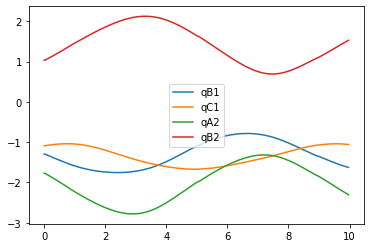

In [52]:
# States:

plt.figure()
artists = plt.plot(t,states[:,1:5])
plt.legend(artists,['qB1','qC1','qA2','qB2'])

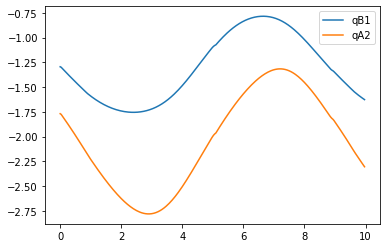

In [53]:
# Determine Angles for Acuated Joints:

B1 = states[:,1]
A2 = states[:,3]
plt.figure()
plt.plot(t,B1)
plt.plot(t,A2)
plt.legend(artists,['qB1','qA2'])

## A2 Servo Actuation:

In [54]:
A = numpy.array([numpy.sin(0.475757575757576*1.5*t-0.4)]).T

In [55]:
def myfunc(k):
    # make sure our coefficients are in the form of a numpy array
    k = numpy.array(k)
    # generate y* = Ak^T
    A2_model = A.dot(k.T)
    # sum the square of the error of our model against the input data, y_rand
    error = ((A2_model-A2)**2).sum()
    #return the error
    return error

In [56]:
ini = [0.1]*A.shape[1]
ini

[0.1]

In [57]:
sol = scipy.optimize.minimize(myfunc,ini)
k_optimum = sol.x
k_optimum

array([-0.72247829])

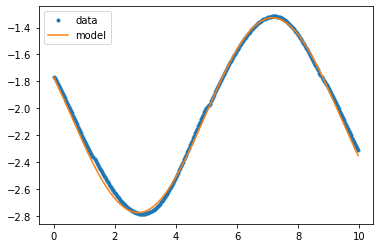

In [58]:
A2_model = A.dot(k_optimum.T)
fig = plt.figure()
ax = fig.add_subplot()
a = ax.plot(t,A2,'.')
b = ax.plot(t,A2_model-2.05)
ax.legend(a+b,['data','model'])

Angle_A2 = -0.91040147*sin(0.7125*t-0.2)-1.8 (4/7 Original Gait Size)

Angle_A2 = -0.78204287*sin(0.7125*t-0.2)-1.8 (1/2 Original Gait Size)

Angle_A2 = -0.53581099*sin(0.7125*t-0.2)-1.9 (1/3 Original Gait Size)

Angle_A2 = -0.42250283*sin(0.7125*t-0.2)-1.9 (1/4 Original Gait Size)

Angle_A2 = -0.3560051*sin(0.7125*t-0.2)-1.9 (1/5 Original Gait Size)

----------------------------------------------------------------------

Angle_A2 = -0.7614001*sin(0.7125*t-0.2)-1.95 (1/2 Original Gait Size/New End Effector Length)

----------------------------------------------------------------------

Angle_A2 = -0.72247829*sin(0.7125*t-0.4)-2.05 (1/2 Original Gait Size/New End Effector Length/Raised Start_y from -0.12 to -0.115)

----------------------------------------------------------------------

Final Equations:

Angle_A2 = -0.72247829*sin(0.7125*t-0.4)-2.05 (1/2 Original Size/New End Effector Length/Raised Start_y from -0.12 to -0.115/Increased Ellipse Size in the Y-Direction)

Angle_A2 = -0.43562765*sin(0.7125*t-0.55)-2.1 (1/3 Original Size/New End Effector Length/Raised Start_y from -0.12 to -0.115/Increased Ellipse Size in the Y-Direction)

Angle_A2 = -0.2692595*sin(0.7125*t-0.7)-2.1 (1/4 Original Size/New End Effector Length/Raised Start_y from -0.12 to -0.115/Increased Ellipse Size in the Y-Direction)

Angle_A2 = -0.79126349*sin(0.7125*t-0.45)-2.0 (4/7 Original Size/New End Effector Length/Raised Start_y from -0.12 to -0.115/Increased Ellipse Size in the Y-Direction)

## B1 Servo Actuation:

In [59]:
A = numpy.array([numpy.sin(0.475757575757576*1.5*t-0.05)]).T

In [60]:
def myfunc(k):
    # make sure our coefficients are in the form of a numpy array
    k = numpy.array(k)
    # generate y* = Ak^T
    B1_model = A.dot(k.T)
    # sum the square of the error of our model against the input data, y_rand
    error = ((B1_model-B1)**2).sum()
    #return the error
    return error

In [61]:
ini = [0.1]*A.shape[1]
ini

[0.1]

In [62]:
sol = scipy.optimize.minimize(myfunc,ini)
k_optimum = sol.x
k_optimum

array([-0.60836185])

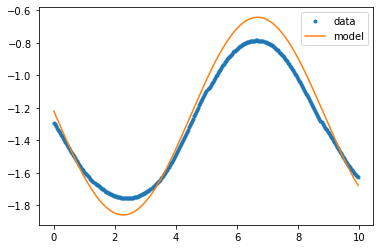

In [63]:
B1_model = A.dot(k_optimum.T)
fig = plt.figure()
ax = fig.add_subplot()
a = ax.plot(t,B1,'.')
b = ax.plot(t,B1_model-1.25)
ax.legend(a+b,['data','model'])

Angle_B1 = -0.6932783*sin(0.7125*t-0.05)-1.225  (4/7 Original Size (Maxiumum Size))

Angle_B1 = -0.60974595*sin(0.7125*t-0.05)-1.225  (1/2 Original Size)

Angle_B1 = -0.43371545*sin(0.7125*t-0.05)-1.225  (1/3 Original Size)

Angle_B1 = -0.3504264*sin(0.7125*t-0.05)-1.225  (1/4 Original Size)

Angle_B1 = -0.30113927*sin(0.7125*t-0.05)-1.225  (1/5 Original Size)

----------------------------------------------------------------------

Angle_B1 = -0.59611036*sin(0.7125*t-0.05)-1.225   (1/2 Original Size/New End Effector Length)

----------------------------------------------------------------------

Angle_B1 = -0.59918397*sin(0.7125*t-0.05)-1.25   (1/2 Original Size/New End Effector Length/Raised Start_y from -0.12 to -0.115)

----------------------------------------------------------------------

Final Equations:

Angle_B1 = -0.60836185*sin(0.7125*t-0.05)-1.25   (1/2 Original Size/New End Effector Length/Raised Start_y from -0.12 to -0.115/Increased Ellipse Size in the Y-Direction)

Angle_B1 = -0.44156115*sin(0.7125*t-0.05)-1.3   (1/3 Original Size/New End Effector Length/Raised Start_y from -0.12 to -0.115/Increased Ellipse Size in the Y-Direction)

Angle_B1 = -0.35929823*sin(0.7125*t-0.05)-1.3   (1/4 Original Size/New End Effector Length/Raised Start_y from -0.12 to -0.115/Increased Ellipse Size in the Y-Direction)

Angle_B1 = -0.6768732*sin(0.7125*t-0.05)-1.25   (4/7 Original Size/New End Effector Length/Raised Start_y from -0.12 to -0.115/Increased Ellipse Size in the Y-Direction)

## Plot of Actuation:

2022-04-27 20:28:43,757 - pynamics.output - INFO - calculating outputs
2022-04-27 20:28:43,814 - pynamics.output - INFO - done calculating outputs


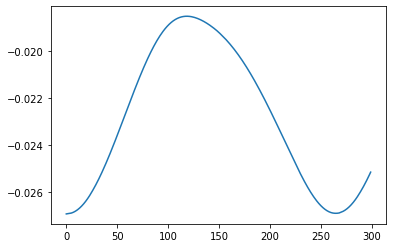

In [64]:
# Energy:

KE = system.get_KE()
PE = system.getPEGravity(pNA1) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

Note that the total energy  of the system does not purely decay over time because the sinusoidal input torques add energy to the system.

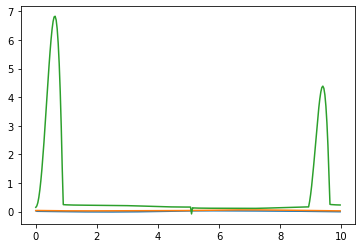

In [65]:
# Constraint Forces:

if use_constraints:
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)

2022-04-27 20:28:45,417 - pynamics.output - INFO - calculating outputs
2022-04-27 20:28:45,473 - pynamics.output - INFO - done calculating outputs


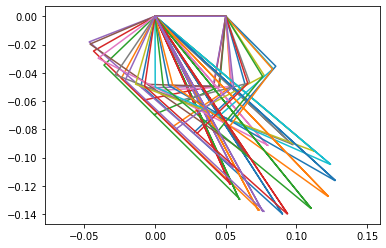

In [66]:
# Motion:

points = [pC1B2,pB1C1,pA1B1,pNA1,pEnd,pNA2,pA2B2,pB2C1,pB2A3]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

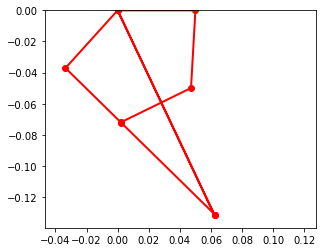

In [67]:
# Motion Animation:

points_output.animate(fps = fps,movie_name = 'triple_pendulum.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

## Bibliography:

[1] J. Kim, K. A. Kazmierczak, and G. J. Breur, “Comparison of temporospatial and kinetic variables of walking in small and large dogs on a pressure-sensing walkway,” *American Journal of Veterinary Research*, vol. 72, no. 9, pp. 1171–1177, 2011.
 
[2] M. S. Fischer, “Dogs in Motion, Prof. Dr. Martin S. Fischer, KYON Symposium 2017,” 30-Dec-2019. [Online]. Available: https://www.youtube.com/watch?v=rAvOPCp6Itk.